# Sports Dataset

10,000 random photos from soccer matches captured at a single timestamp make up the dataset. Every snapshot has a number of elements that offer details on the current match. The objective of the dataset is to capture the evolving dynamics of a soccer game, and to make predictions for the number of goals that will be scored for the remaining playing time.

# Dataset Structure

The dataset is presented in a single file with 10,000 rows and 20 columns, each row representing a snapshot of a soccer match, and each column representing a specific attribute or feature of that snapshot.

Number of Instances (Rows): 10,000 instances 
Number of Features (Columns): 20 features/columns 

# Feature Representation

The features include identifiers such as uuid, and dynamic match-related details such as the current minute of play, home and away team scores, yellow and red cards for both teams, the number of attacks and dangerous attacks by each team, corners awarded, shots on and off target for both teams, and the ball possession percentage for both the home and away teams until the current minute.

# Libraries

- pandas
- numpy
- matplotlib
- pickle
- os
- sklearn.neighbors KNeighborsClassifier
- sklearn.metrics accuracy_score, classification_report, mean_squared_error, r2_score
- sklearn.model_selection cross_val_predict, cross_val_score, train_test_split
- sklearn preprocessing 
- sklearn.linear_model LinearRegression

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import seaborn as sns
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV,LogisticRegressionCV

In [224]:
df = pd.read_csv(filepath_or_buffer = 'Dataset 3 - Sports Dataset/sports.csv', header = 0)
df

,uuid,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,...,away_dangerous_attacks,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta
0,2f9dd904-8d9d-4aa0-a9d9-4e0f3e50d742,94,1,2,0,0,0,0,39,45,...,26,4,1,4,0,4,6,48,52,1
1,869c1420-9153-4d73-8d79-5db31a8a80a4,91,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50,50,1
2,549e25a3-4c93-459d-b115-fb303273c78a,3,0,0,0,0,0,0,3,1,...,0,0,0,0,0,0,0,62,38,4
3,287b4be5-9163-4e2e-895d-d11052a97410,17,0,0,1,0,0,0,41,46,...,25,1,0,0,2,0,0,55,45,2
4,a607da6a-d6b2-4652-b7a5-6c8e4b61c2b8,76,1,0,1,0,0,0,69,78,...,46,1,1,0,3,4,4,45,55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,838f35c5-afa3-474b-876e-063fd49d4326,32,0,0,0,0,0,0,16,25,...,13,0,1,1,2,0,1,45,55,0
6996,4bcfd248-5f39-4af2-b465-5358c9e7088e,101,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,50,50,0
6997,deccdc2c-625e-495a-9b06-02d540d4cd24,78,1,0,0,0,0,0,71,60,...,40,7,0,5,5,7,0,61,39,2
6998,94a20308-55d8-47cb-8f8b-d2702a531c74,72,2,0,0,0,0,0,85,66,...,20,3,0,4,1,2,1,52,48,0


# Data Preprocessing
Our objective for this project is to use the data given in the dataset to predict whether 1 or more goals can be scored in the remaining playing time of the match.

In [225]:
# Handling Missing Data
df.dropna(inplace=True)
# delete duplicates
df.drop_duplicates('uuid',inplace = True)
try:
    df = df.drop(['uuid'], axis=1)
except:
    print('uuid dropped already')
# Feature Scaling
numerical_features = ['current_minute', 'home_score', 'away_score', 'home_yellow_cards', 'away_yellow_cards',
                      'home_red_cards', 'away_red_cards', 'home_attacks', 'away_attacks', 'home_dangerous_attacks',
                      'away_dangerous_attacks', 'home_corners', 'away_corners', 'home_off_target', 'away_off_target',
                      'home_on_target', 'away_on_target', 'home_possession', 'away_possession']

dropping any data out of the current game. a game only has 105 minutes including halftime.

In [226]:
df = df.query("0<=current_minute<=105")

 remove rows during halftime. probably an exhibition match.
 actual play time is 90 minutes. last minute of first half should be minute 44.half time lasts 15.
 First minute of last half starts at minute 60. all the minutes in last half needs to be subtracted by 15 to make data conitiguous

In [227]:
df = df.query("44>= current_minute | current_minute >= 60")
fun = lambda t: t-15 if t >=60 else t
df['current_minute']=df['current_minute'].apply(fun)

  Create variable for the <!-- remaining time and the--> target. the target indicates whether 1 goal or more will be scored with the remaining time of the match. it shows binary values 

In [228]:
# df['remaining_time'] = df['current_minute'].max() - df['current_minute']
df['target'] = (df['home_score'] + df['away_score']).apply(lambda x: 1 if x > 0 else 0)
df.sort_values(by = ['current_minute'],inplace = True,axis = 0)
# df = df.groupby(df['current_minute']).aggregate('sum')
# df['current_minute'] = df.index

In [229]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [230]:
# Current shape of our X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6577, 20)
Shape of y: (6577,)


# Exploratory Data Analysis

This is the content of the dataset

In [231]:
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,...,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta,target
2554,0,0,0,0,0,0,0,6,0,1,...,0,0,0,0,0,0,80,20,2,0
2602,0,0,0,0,0,0,0,2,2,1,...,0,0,0,0,0,0,44,56,0,0
2272,0,0,0,0,0,0,0,2,1,1,...,0,0,0,0,0,0,79,21,7,0
4331,0,0,0,0,0,0,0,2,1,3,...,0,0,0,0,1,0,36,64,2,0
3144,0,0,0,0,0,0,0,1,3,0,...,0,0,0,0,0,0,40,60,0,0


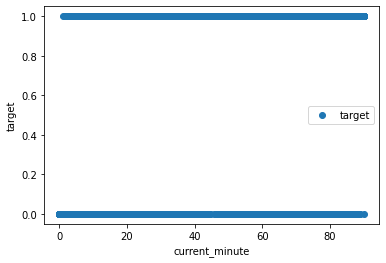

In [232]:
df.plot(x='current_minute', y='target', style='o')
plt.xlabel('current_minute')
plt.ylabel('target')
plt.show()

Basic summary statistics for numerical values

In [233]:
print("\nSummary statistics of numerical features:")
df.describe()


Summary statistics of numerical features:


,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,...,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta,target
count,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,...,6577.00000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000,6577.000000
mean,49.804926,0.783032,0.608332,0.510263,0.592215,0.008515,0.014900,45.755968,42.857686,27.212863,...,2.33161,1.971111,3.016573,2.551163,2.136688,1.759313,51.581572,48.415235,1.427855,0.649536
std,26.441958,1.068046,0.911459,0.907488,1.007297,0.093528,0.122412,36.029737,33.539557,22.968335,...,2.44227,2.192337,3.138122,2.719920,2.316965,2.002735,10.542929,10.544736,1.423859,0.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000
25%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,13.000000,7.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,42.000000,0.000000,0.000000
50%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,40.000000,24.000000,...,2.00000,1.000000,2.000000,2.000000,2.000000,1.000000,51.000000,49.000000,1.000000,1.000000
75%,72.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,71.000000,67.000000,42.000000,...,4.00000,3.000000,5.000000,4.000000,3.000000,3.000000,58.000000,54.000000,2.000000,1.000000
max,90.000000,8.000000,9.000000,8.000000,8.000000,2.000000,2.000000,255.000000,183.000000,132.000000,...,14.00000,18.000000,24.000000,18.000000,22.000000,19.000000,100.000000,100.000000,10.000000,1.000000


Scatterplot matrix for pairs of numerical features


Pairplot for numerical features:


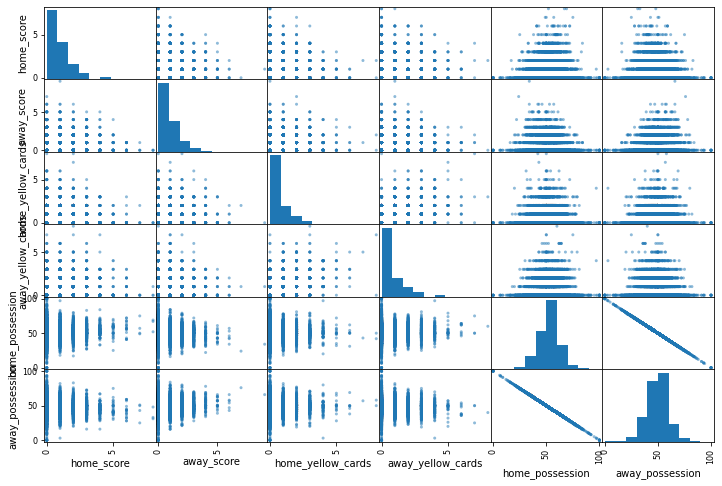

In [234]:
print("\nPairplot for numerical features:")
scatter_matrix = pd.plotting.scatter_matrix(df[['home_score', 'away_score', 'home_yellow_cards', 'away_yellow_cards', 'home_possession', 'away_possession']], figsize=(12, 8))
plt.show()

Histogram that shows the distribution of home and away scores


Distribution of home and away scores:


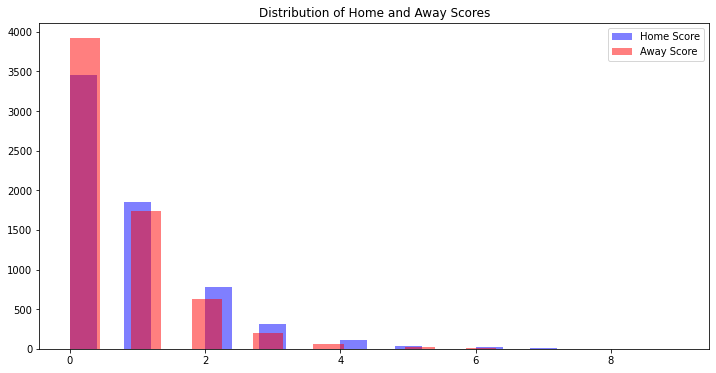

In [235]:
print("\nDistribution of home and away scores:")
plt.figure(figsize=(12, 6))
plt.hist(df['home_score'], bins=20, alpha=0.5, label='Home Score', color='blue')
plt.hist(df['away_score'], bins=20, alpha=0.5, label='Away Score', color='red')
plt.title('Distribution of Home and Away Scores')
plt.legend()
plt.show()

# Logistic Regression Model

In [236]:
# Initialize Linear Regression Model
linreg = LogisticRegression(solver = 'sag',max_iter = 10000, n_jobs = -1)
linreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, solver='sag')

First, we will perform Linear Regression on the Training set.

In [237]:
# Make predictions on the training set
train_predictions = linreg.predict(X_train)
# Convert predictions to binary (0 or 1)
# train_predictions_binary = (train_predictions >= 0.5).astype(int)

To evaluate the model, we will get the training accuracy

In [238]:
# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, train_predictions)
train_conf_matrix = confusion_matrix(y_train, train_predictions)
train_classification_rep = classification_report(y_train, train_predictions)

print("Train Accuracy:", train_accuracy)
print("Train Confusion Matrix:\n", train_conf_matrix)
print("Train Classification Report:\n", train_classification_rep)

Train Accuracy: 1.0
Train Confusion Matrix:
 [[1824    0]
 [   0 3437]]
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1824
           1       1.00      1.00      1.00      3437

    accuracy                           1.00      5261
   macro avg       1.00      1.00      1.00      5261
weighted avg       1.00      1.00      1.00      5261



Based on the results, we can see that we got an accuracy of about 93% which indicates that the model predicted the target correctly for 93% of the instances in the train set. 

Train Confusion Matrix:

True Positives: 3331
True Negatives: 1877
False Positives: 53
False Negatives: 339

In terms of accuracy, the model has a good performance on the train set in terms of precision, recall, and F1-score for both classes. Class 0 has slightly higher precision, while class 1 has slightly higher recall. The weighted average F1-score is 0.93, indicating good overall performance.

In [239]:
# Calculate RMSE and R2 Score for the training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_r2 = r2_score(y_train, train_predictions)

print(f"Training RMSE: {train_rmse}")
print(f"Training R2 Score: {train_r2}")

Training RMSE: 0.0
Training R2 Score: 1.0


The rmse is at about 33% and the R2 score is about 50%. The R2 score indicates that the model explains about 50% of the variance in the target in the train set. The model needs improvement, especially in terms of reducing the RMSE.

Now that we have the train accuracy, rmse, and r-squared values, let's visualize our results on a graph.

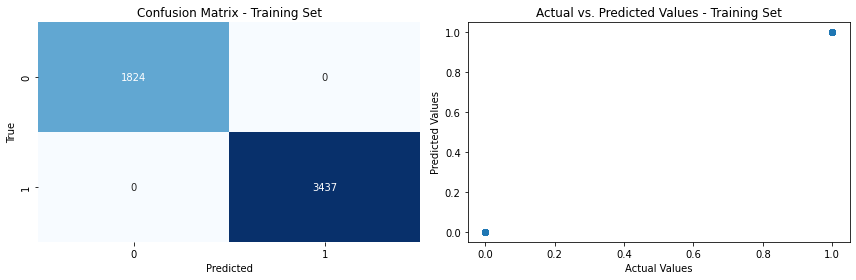

In [240]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix - Training Set')

# Scatter Plot for Actual vs. Predicted Values
axes[1].scatter(y_train, train_predictions, alpha=0.5)
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Actual vs. Predicted Values - Training Set')
plt.tight_layout()
plt.show()

We will now create a validation set to further assess our model.

In [241]:
# Split the data again for the validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [242]:
val_predictions = linreg.predict(X_val)
val_predictions_binary = (val_predictions >= 0.5).astype(int)

We have created the validation set. Now we will evaluate the model on it.

In [243]:
# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, val_predictions)
val_conf_matrix = confusion_matrix(y_val, val_predictions)
val_classification_rep = classification_report(y_val, val_predictions)

print("\nValidation Accuracy:", val_accuracy)
print("Validation Confusion Matrix:\n", val_conf_matrix)
print("Validation Classification Report:\n", val_classification_rep)


Validation Accuracy: 1.0
Validation Confusion Matrix:
 [[481   0]
 [  0 835]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       481
           1       1.00      1.00      1.00       835

    accuracy                           1.00      1316
   macro avg       1.00      1.00      1.00      1316
weighted avg       1.00      1.00      1.00      1316



The model achieved a high accuracy of approximately 91.6% on the validation set. The model performs well on the validation set with high precision, recall, and F1-Score for both classes.

Confusion Matrix:

True Positives: 834
True Negatives: 448
False Positives: 14
False Negatives: 104

The high accuracy, combined with balanced precision and recall, suggests that the model generalizes well to new data. The validation results indicate that the model is performing effectively on unseen data, and its predictions are reliable. 

In [244]:
# Calculate RMSE and R2 Score for the validation set
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_r2 = r2_score(y_val, val_predictions)

print(f"Validation RMSE: {val_rmse}")
print(f"Validation R2 Score: {val_r2}")

Validation RMSE: 0.0
Validation R2 Score: 1.0


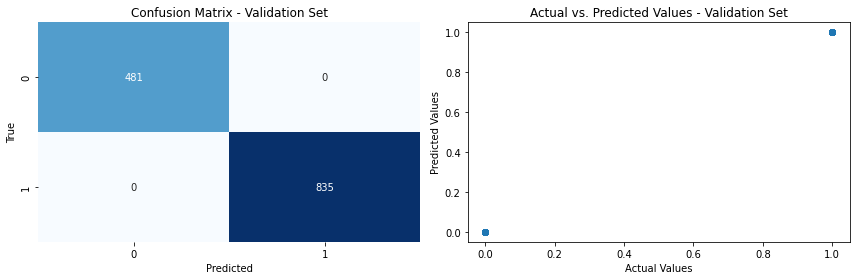

In [245]:
# Confusion Matrix Plot for Validation Set
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix - Validation Set')

# Scatter Plot for Actual vs. Predicted Values - Validation Set
axes[1].scatter(y_val, val_predictions, alpha=0.5)
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Actual vs. Predicted Values - Validation Set')

plt.tight_layout()
plt.show()

After evaluating the model on the validation set, we will now evaluate it on the test set.

In [246]:
# Make predictions on the test set
test_predictions = linreg.predict(X_test)
test_predictions_binary = (test_predictions >= 0.5).astype(int)

In [247]:
# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, test_predictions_binary)
test_conf_matrix = confusion_matrix(y_test, test_predictions_binary)
test_classification_rep = classification_report(y_test, test_predictions_binary)

print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)
print("Test Classification Report:\n", test_classification_rep)

Test Accuracy: 1.0
Test Confusion Matrix:
 [[481   0]
 [  0 835]]
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       481
           1       1.00      1.00      1.00       835

    accuracy                           1.00      1316
   macro avg       1.00      1.00      1.00      1316
weighted avg       1.00      1.00      1.00      1316



In [248]:
# Calculate RMSE and R2 Score for the test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"Test RMSE: {test_rmse}")
print(f"Test R2 Score: {test_r2}")

Test RMSE: 0.0
Test R2 Score: 1.0


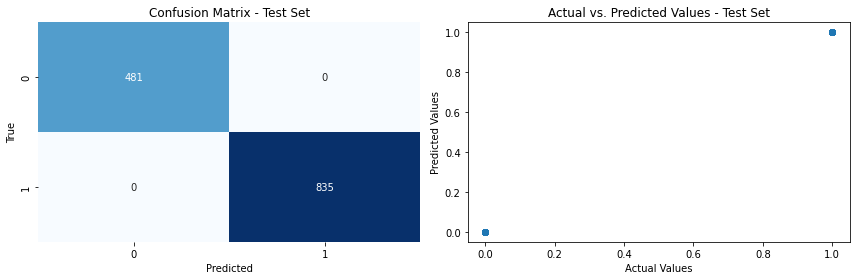

In [249]:
# Confusion Matrix Plot for Test Set
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix - Test Set')

# Scatter Plot for Actual vs. Predicted Values - Test Set
axes[1].scatter(y_test, test_predictions, alpha=0.5)
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Actual vs. Predicted Values - Test Set')

plt.tight_layout()
plt.show()

Based on the results of the test set evaluation, we can see that it is consistent with the validation set as both show the same values in terms of accuracy, classification, and confusion matrix. Given the consistency of both results, we can see that we have a robust model. 

Though the model is performing well in terms of accuracy, it still has a shortcoming in capturing the class (1). Further improvements can still be implemented through hyperparameter tuning.

# Hyperparameter Tuning

We Will be using Lasso Regularization on the model to find the best value of alpha, and to try to enhance the model's performance on the test set. 

In [265]:
# alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
# Lasso regression model with cross-validated alpha selection
lasso_cv = LogisticRegressionCV( cv=5)
lasso_cv.fit(X_train, y_train)

# Get the best alpha
best_alpha = lasso_cv.Cs

# Train the model with the best alpha
lasso_reg_best = LogisticRegression(C=best_alpha, random_state=42)
lasso_reg_best.fit(X_train, y_train)

# Make predictions on the test set
test_predictions = lasso_reg_best.predict(X_test)
test_predictions_binary = (test_predictions >= 0.5).astype(int)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
test_conf_matrix = confusion_matrix(y_test, test_predictions)
test_classification_rep = classification_report(y_test, test_predictions)

print("Best Alpha:", best_alpha)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:\n", test_conf_matrix)
print("Test Classification Report:\n", test_classification_rep)

c:\python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Best Alpha: 10
Test Accuracy: 1.0
Test Confusion Matrix:
 [[481   0]
 [  0 835]]
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       481
           1       1.00      1.00      1.00       835

    accuracy                           1.00      1316
   macro avg       1.00      1.00      1.00      1316
weighted avg       1.00      1.00      1.00      1316



c:\python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result